<a href="https://colab.research.google.com/github/huankoh/PSICHIC/blob/main/selectivity/PSICHIC_Selectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSICHIC<sub>XL</sub> Selectivity Profiling $_{\mathbb{BETA}}$

## Input Needed

- **Only Sequence Data**: Protein Sequence + Ligand SMILES pairs.

## PSICHIC<sub>XL</sub>

- **Reduced Off-Target Effects:**: Minimize unintended interactions, enhancing drug safety profiles.
- **Fast and Efficient**: PSICHIC<sub>XL</sub> Selectivity Profiling can be fast even with thousands of protein sequences.
- **Case Study Validated**: Proven effectiveness through a detailed case study on AR subtypes.


## Current Version
This notebook is a beta version, demonstrating how PSICHIC<sub>XL</sub> can be utilized for selectivity profiling. The complete version will be released once the paper is updated and the selectivity profiling section is publicly available.

In [1]:
%%time
#@title Setting up PSICHIC Online Platform (~2 min 30 sec)
import os, time

# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

os.system(f"pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html")
os.system(f"pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html")
os.system(f"pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html")
os.system(f"pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html")
os.system(f"pip install torch-geometric")

os.system("pip install rdkit")
os.system("pip install biopython")
os.system("pip install biopandas")
os.system("pip install py3Dmol")
os.system("pip install timeout_decorator")
os.system("pip install cairosvg")
os.system("pip install umap-learn")
os.system("pip install plotly")
os.system("pip install --upgrade plotly")
os.system("pip install mplcursors")

os.system("pip install lifelines")
os.system("pip install reprint")
os.system("pip install 'fair-esm'")

# install PSICHIC
!git clone https://github.com/huankoh/PSICHIC.git

import torch
import os
import pandas as pd
from IPython.display import SVG
from rdkit import Chem
import numpy as np
%cd PSICHIC

Cloning into 'PSICHIC'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 185 (delta 62), reused 58 (delta 19), pack-reused 46
Receiving objects: 100% (185/185), 52.05 MiB | 33.91 MiB/s, done.
Resolving deltas: 100% (73/73), done.
/content/PSICHIC
CPU times: user 2.71 s, sys: 484 ms, total: 3.19 s
Wall time: 2min 58s


In [2]:
#@title Importing functions
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from ipywidgets import Button, Layout, jslink, IntText, IntSlider
import io
import IPython
from ipywidgets import GridspecLayout
from ipywidgets import Output

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import Bio.PDB as PDB

import py3Dmol


from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import Draw
import pickle

from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc
import warnings
from rdkit.Chem import AllChem

from rdkit.Chem import rdMolAlign
import timeout_decorator
@timeout_decorator.timeout(600)  # Set the timeout to 10 minutes (600 seconds)


def read_molecule(molecule_file, sanitize=False, calc_charges=False, remove_hs=True):
    if molecule_file.endswith('.mol2'):
        mol = Chem.MolFromMol2File(molecule_file, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.sdf'):
        supplier = Chem.SDMolSupplier(molecule_file, sanitize=False, removeHs=False)
        mol = supplier[0]
    elif molecule_file.endswith('.pdbqt'):
        with open(molecule_file) as file:
            pdbqt_data = file.readlines()
        pdb_block = ''
        for line in pdbqt_data:
            pdb_block += '{}\n'.format(line[:66])
        mol = Chem.MolFromPDBBlock(pdb_block, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.pdb'):
        mol = Chem.MolFromPDBFile(molecule_file, sanitize=False, removeHs=False)
    else:
        raise ValueError('Expect the format of the molecule_file to be '
                         'one of .mol2, .sdf, .pdbqt and .pdb, got {}'.format(molecule_file))

    try:
        if sanitize or calc_charges:
            Chem.SanitizeMol(mol)

        if calc_charges:
            # Compute Gasteiger charges on the molecule.
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                warnings.warn('Unable to compute charges for the molecule.')

        if remove_hs:
            mol = Chem.RemoveHs(mol, sanitize=sanitize)

    except Exception as e:
        # print(e)
        return None

    return mol


def read_mol(mol_path, remove_hs=False):
    lig = None
    if '.sdf' in mol_path:
        lig = read_molecule(mol_path, remove_hs=remove_hs, sanitize=True)
    elif '.mol2' in mol_path:  # read mol2 file if sdf file cannot be sanitized
        lig = read_molecule(mol_path, remove_hs=remove_hs, sanitize=True)
    if lig is None:
        raise Exception("Fail to read ligand path")

    return lig



show_sidechains=False

mapper = plt.get_cmap('Reds', )
color_map = {}


one_to_three = {"A" : "ALA",
              "C" : "CYS",
              "D" : "ASP",
              "E" : "GLU",
              "F" : "PHE",
              "G" : "GLY",
              "H" : "HIS",
              "I" : "ILE",
              "K" : "LYS",
              "L" : "LEU",
              "M" : "MET",
              "N" : "ASN",
              "P" : "PRO",
              "Q" : "GLN",
              "R" : "ARG",
              "S" : "SER",
              "T" : "THR",
              "V" : "VAL",
              "W" : "TRP",
              "Y" : "TYR",
              "B" : "ASX",
              "Z" : "GLX",
              "X" : "UNK",
              "*" : " * "}

three_to_one = {}
for _key, _value in one_to_three.items():
    three_to_one[_value] = _key
three_to_one["SEC"] = "C"
three_to_one["MSE"] = "M"


def overwrite_b_factors(structure,
                        custom_bfactors: np.ndarray, res_symbols: list,
                        save_path=None) -> str:

    curr_resid = ('', '', '')
    idx = -1
    a_list = []
    for i, chain in enumerate(structure):
        for res_idx, residue in enumerate(chain):
            if residue.get_resname() == 'HOH':
                for atom in residue:
                    atom.bfactor = 0

            c_alpha, n, c = None, None, None
            for atom in residue:
                if atom.name == 'CA':
                    c_alpha = list(atom.get_vector())
                if atom.name == 'N':
                    n = list(atom.get_vector())
                if atom.name == 'C':
                    c = list(atom.get_vector())
            if c_alpha != None and n != None and c != None:
                idx += 1

                for atom in residue:
                    ##### ensure visualization SEQ follows pre-processed SEQ
                    try:
                        pdb_res_symbol = three_to_one[residue.get_resname()]
                    except Exception as e:
                        pdb_res_symbol = 'X'
                        # print("encountered unknown AA: ", residue.get_resname(), ' in the complex. Replacing it with a dash X.')

                    if res_symbols[idx] != pdb_res_symbol:
                        raise Exception('Result sequence symbol {} does not match with PDB sequence symbol {}'.format(res_symbols[idx],pdb_res_symbol))

                    atom.bfactor = custom_bfactors[idx]
            else:
                for atom in residue:
                    atom.bfactor = 0
    if save_path is None:
        path_out = 'temporary.txt'
    else:
        path_out = save_path
    new_pdb = io.StringIO()
    pdb_io = PDB.PDBIO()
    pdb_io.set_structure(structure)
    pdb_io.save(path_out)

    with open(path_out,'r') as f:
        out = f.read()

    return out

for v in range(100+1):
    rgba = mapper(v/100)
    color_map[v/100] = rgb2hex(rgba)

def alphafold_plot(to_visualize_pdb):
    view = py3Dmol.view(width=800, height=600)
    view.addModelsAsFrames(to_visualize_pdb)
    style = {'cartoon': {'colorscheme': {'prop': 'b', 'map': color_map}}}
    if show_sidechains:
        style['stick'] = {}
    view.setStyle({'model': -1}, style)
    view.zoomTo()
    return view

def generate_ESM_structure(jobname, sequence):
    def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
    alphabet_list = list(ascii_uppercase+ascii_lowercase)

    jobname = re.sub(r'\W+', '', jobname)[:50]

    sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
    sequence = re.sub(":+",":",sequence)
    sequence = re.sub("^[:]+","",sequence)
    sequence = re.sub("[:]+$","",sequence)
    copies = 1
    sequence = ":".join([sequence] * copies)
    num_recycles = 3
    chain_linker = 25

    ID = jobname+"_"+get_hash(sequence)[:5]
    seqs = sequence.split(":")
    lengths = [len(s) for s in seqs]
    length = sum(lengths)
    print("length",length)

    u_seqs = list(set(seqs))
    if len(seqs) == 1: mode = "mono"
    elif len(u_seqs) == 1: mode = "homo"
    else: mode = "hetero"

    if "model" not in dir() or model_name != model_name_:
        if "model" in dir():
            # delete old model from memory
            del model
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        model = torch.load(model_name)
        model.eval().cuda().requires_grad_(False)
        model_name_ = model_name

    # optimized for Tesla T4
    if length > 700:
        model.set_chunk_size(64)
    else:
        model.set_chunk_size(128)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    output = model.infer(sequence,
                        num_recycles=num_recycles,
                        chain_linker="X"*chain_linker,
                        residue_index_offset=512)

    pdb_str = model.output_to_pdb(output)[0]

    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return pdb_str


def plot_visual(protein_csv, ligand_pickle,  protein_path=None, ligand_path=None, save_id='',
                residue_color_type='Original', show_protein_surface=True,
                show_protein_mainchain=False,show_protein_sidechain=False):
    protein_df = pd.read_csv(protein_csv)
    if residue_color_type == 'Original':
        residue_scores = protein_df['PSICHIC_Residue_Score'].round(2).clip(0.01,0.99).tolist()
    else:
        residue_scores = protein_df['PSICHIC_Residue_Percentile'].round(2).clip(0.01,0.99).tolist()

    if protein_path:
        parser = PDB.PDBParser(QUIET=True)
        structure = parser.get_structure('', protein_path)[0]
        protein_pdb_block = overwrite_b_factors(structure, residue_scores, protein_df['Residue_Type'].tolist())
    else:
        print('No PDB detected - generating in silico structure from ESM')
        pdbstr = generate_ESM_structure(save_id + '_ESM.pdb', ''.join(protein_df['Residue_Type'].tolist()))
        torch.cuda.empty_cache()

        parser = PDB.PDBParser(QUIET=True)
        handle = io.StringIO(pdbstr)
        structure = parser.get_structure('', handle)[0]
        protein_pdb_block = overwrite_b_factors(structure, residue_scores, protein_df['Residue_Type'].tolist())


    ligand_pdb_block = None
    if ligand_path:
        ligand = read_mol(ligand_path)
        ligand_pdb_block = Chem.MolToPDBBlock(ligand)


    view = DrawDocking(protein_pdb_block, ligand_pdb_block,
                       show_protein_surface=show_protein_surface,
                        show_protein_mainchain=show_protein_mainchain,
                        show_protein_sidechain=show_protein_sidechain)
    grid = GridspecLayout(1,2, layout=Layout(width='80%', height='80%'))
    out = Output()
    with out:
        view.show()
    grid[0, 0] = out

    ## atom scores
    with open(ligand_pickle,'rb') as f:
        mol = pickle.load(f)

    ligand_contribs = []
    for idx, atom in enumerate(mol.GetAtoms()):
        psichic_atom_score = atom.GetProp("PSICHIC_Atom_Score")
        atom.SetProp('score',psichic_atom_score)
        ligand_contribs.append(float(psichic_atom_score.replace('[','').replace(']','')))


    d1 = Draw.MolDraw2DSVG(500, 500)
    def make_darker(color, scale):
        r, g, b, a = color
        return (r * scale, g * scale, b * scale, a)

    start_color = mcolors.hex2color('#40d0e0')
    middle_color = mcolors.hex2color('white')
    end_color = mcolors.hex2color('#40d0e0')
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'custom_cmap', [start_color, middle_color, end_color])
    darker_first_color = make_darker(cmap(0), 0.8)
    darker_last_color = make_darker(cmap(1), 0.8)

    colorMap = LinearSegmentedColormap.from_list('Wistia', [darker_first_color, (1.0, 1.0, 1.0), darker_last_color], N=255)
    SimilarityMaps.GetSimilarityMapFromWeights(mol, ligand_contribs, draw2d=d1, contourLines=10, colorMap=colorMap)
    d1.FinishDrawing()
    svg1 = SVG(d1.GetDrawingText())

    out = Output()
    with out:
        IPython.display.display(svg1)
    grid[0,1] = out
    IPython.display.display(grid)

    return {'protein_pdb_block':protein_pdb_block, 'protein_path':protein_path}, {'ligand_pdb_block':ligand_pdb_block,'ligand2d':mol, 'atom_scores':ligand_contribs, 'ligand_path':ligand_path}


# PSICHIC Sequence-based Selectivity Profiling

- User-Friendly: Just a CSV file with ``'Protein`` and ``Ligand`` columns needed. It is desriable to also include an ``ID`` column to refer each unique pair during your analysis at later stage. If ``ID`` is missing, we will include an ID based on the row number (PAIR_1, ..., PAIR_N).

Your CSV should look something like this:

| ID | Protein | Ligand |
|:----------:|:----------:|:----------:|
| Target1| ATCGATCG....  | C1CCCCC1  |
| Target2| GCTAGCTA....  | C1CCCCC1 |
|...|...| ...|
|Target1000|TACGTACG | C1CCCCC1  |

- Fast Yet Insightful: As a selectivity profiling platform, your CSV file will likely resemble the format above, where each ligand is compared against multiple proteins.

- For now, we are using the adenosine receptors interaction demo file we prepared below. Please feel free to try your protein of interest!

In [3]:
#@title 1. Read Adenosine Receptors (ARs) Interaction Demo File

import io
import pandas as pd
from google.colab import files

jobname = "AR_SELECTIVITY_PROFILES"
filename = 'selectivity/ar_selectivity_demo_data.csv'

In [4]:
#@title 2. Run screening using PSICHIC
batch_size=16
trained_model_path = 'trained_weights/multitask_PSICHIC'

screenfile = filename
result_path = jobname
#@markdown Three substep you will observe is (1) Initialising Protein, (2) Initialising Ligand and (3) Start Screening.

import json
import pandas as pd
import torch
import numpy as np
import os
import random
# Utils
from utils.utils import DataLoader, virtual_screening
from utils.dataset import *  # data
from utils.trainer import Trainer
from utils.metrics import *
# Preprocessing
from utils import protein_init, ligand_init
# Model
from models.net import net
# Config
from tqdm import tqdm

device = 'cuda:0'
with open(os.path.join(trained_model_path,'config.json'),'r') as f:
    config = json.load(f)

print("Screening the csv file: {}".format(screenfile))
# device
device = torch.device(device)


if not os.path.exists(result_path):
    os.makedirs(result_path)

degree_dict = torch.load(os.path.join(trained_model_path,'degree.pt'))
param_dict = os.path.join(trained_model_path,'model.pt')
mol_deg, prot_deg = degree_dict['ligand_deg'],degree_dict['protein_deg']

model = net(mol_deg, prot_deg,
            # MOLECULE
            mol_in_channels=config['params']['mol_in_channels'],  prot_in_channels=config['params']['prot_in_channels'],
            prot_evo_channels=config['params']['prot_evo_channels'],
            hidden_channels=config['params']['hidden_channels'], pre_layers=config['params']['pre_layers'],
            post_layers=config['params']['post_layers'],aggregators=config['params']['aggregators'],
            scalers=config['params']['scalers'],total_layer=config['params']['total_layer'],
            K = config['params']['K'],heads=config['params']['heads'],
            dropout=config['params']['dropout'],
            dropout_attn_score=config['params']['dropout_attn_score'],
            # output
            regression_head=config['tasks']['regression_task'],
            classification_head=config['tasks']['classification_task'] ,
            multiclassification_head=config['tasks']['mclassification_task'],
            device=device).to(device)
model.reset_parameters()
model.load_state_dict(torch.load(param_dict,map_location=device))


screen_df = pd.read_csv(os.path.join(screenfile))
protein_seqs = screen_df['Protein'].unique().tolist()
print('Initialising protein sequence to Protein Graph')
protein_dict = protein_init(protein_seqs)
ligand_smiles = screen_df['Ligand'].unique().tolist()
print('Initialising ligand SMILES to Ligand Graph')
ligand_dict = ligand_init(ligand_smiles)
torch.cuda.empty_cache()
## drop any invalid smiles
screen_df = screen_df[screen_df['Ligand'].isin(list(ligand_dict.keys()))].reset_index(drop=True)
screen_dataset = ProteinMoleculeDataset(screen_df, ligand_dict, protein_dict, device=device)
screen_loader = DataLoader(screen_dataset, batch_size=batch_size, shuffle=False,
                            follow_batch=['mol_x', 'clique_x', 'prot_node_aa'])

print("Screening starts now!")
screen_df = virtual_screening(screen_df, model, screen_loader,
                 result_path=os.path.join(result_path, "interpretation_result"), save_interpret=True,
                 ligand_dict=ligand_dict, device=device)

screen_df.to_csv(os.path.join(result_path,'screening.csv'),index=False)
print('Screening completed and saved to {}'.format(result_path))

Screening the csv file: selectivity/ar_selectivity_demo_data.csv
Initialising protein sequence to Protein Graph


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Initialising ligand SMILES to Ligand Graph


  0%|          | 0/5 [00:00<?, ?it/s]

Screening starts now!


  0%|          | 0/2 [00:00<?, ?it/s]

Screening completed and saved to AR_SELECTIVITY_PROFILES


# PSICHIC<sub>XL</sub>: Promiscuous AR-Adenosine and AR-NECA Interactions

In [5]:
#@title 1. Pick a promiscuous ligand
which_ligand = 'NECA' #@param ["NECA", "ADENOSINE"]

psichic_selectivity_df = pd.read_csv(jobname+"/screening.csv")


## assign functional effect class based on the one with highest probability
def class_predicted(class_num):
    if class_num == 0:
        return 'Antagonist'
    elif class_num == 1:
        return 'Non-binder'
    elif class_num == 2:
        return 'Agonist'

psichic_selectivity_df['predicted_functional_class'] = [class_predicted(i) for i in psichic_selectivity_df.iloc[:,-3:].values.argmax(axis=1)]


which_df = psichic_selectivity_df[psichic_selectivity_df.ID.apply(lambda x: which_ligand in x)].copy()


which_df['subtype'] = which_df.ID.apply(lambda x: x.split('_')[0])


In [6]:
#@title 2. PSICHIC<sub>XL</sub> Interaction Property Prediction
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import Button, Layout, jslink, IntText, IntSlider
import io
import IPython
from ipywidgets import GridspecLayout
from ipywidgets import Output


# Data
constructs = which_df['subtype'].tolist()
predicted_values = which_df['predicted_binding_affinity'].tolist()
scatter_y = which_df['IUPHAR Affinity'].tolist()

# Visual settings
bar_colors = ['white', 'white','white','white']
outline_colors = ['#057CCC', '#DE7704','#843C0C', '#BF8FAD']
scatter_colors = ['#507CCC', '#DE7704','#843C0C', '#BF8FAD']
line_color = 'black'


# Plot settings
x_start = 5
x = np.arange(len(constructs)) + x_start
width = 0.35
fig, ax = plt.subplots(figsize=(7, 6))
adjusted_width = 0.7
line_width = 5  # Width of the outline
# Create bars
for i, x_val in enumerate(x):
    bar = ax.bar(x_val, predicted_values[i], adjusted_width,
                 color=bar_colors[i], capsize=5,
                 edgecolor=outline_colors[i], linewidth=5)
    for rect in bar:
        rect.set_x(rect.get_x() + (line_width / 200))

# Scatter plot data (assumed to be centered)
scatter_x_centered = x  # Adjust if necessary
ax.scatter(scatter_x_centered, scatter_y, s=1000, zorder=5,color='white',edgecolors=scatter_colors,linewidths=5)
ax.plot(scatter_x_centered, scatter_y, color='black',linewidth=2,linestyle='-')

# Customize plot
ax.set_ylim(4., 9.)
ax.tick_params(axis='y', which='major', labelsize=8, length=14, width=2, color='black')
ax.tick_params(axis='x', which='major', labelsize=8, length=0, width=2, color='black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([4,5,6,7,8,9])
ax.set_yticklabels([4,5,6,7,8,9], fontsize=20)  # Set y-tick font size
ax.set_ylabel('Binding Affinity (pKi)', fontsize=30)  # If you have a y-axis label, put the text in the quotes

ax.set_xticks(x)
ax.set_xticklabels(constructs,fontsize=20)


# Create custom legends
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
legend_fontsize = 14
real_legend = mlines.Line2D([], [], color='white', marker='o', markersize=15, label='Real', markeredgewidth=2, markeredgecolor='black', linestyle='None')
prediction_legend = mpatches.Patch(facecolor='white', label='Predicted', edgecolor='black', linewidth=2)  # Set facecolor and edgecolor separately
ax.legend(handles=[real_legend, prediction_legend], fontsize=legend_fontsize)


fig.tight_layout()

grid = GridspecLayout(1,2, layout=Layout(width='80%', height='80%'))
out = Output()
with out:
    plt.show()
grid[0, 0] = out


out = Output()
with out:
    IPython.display.display(which_df[['subtype','predicted_functional_class']])
grid[0,1] = out
IPython.display.display(grid)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [7]:
#@title 3. PSICHIC<sub>XL</sub> Ligand Interpretation - Atom Importance Scores
import pickle
import IPython.core.display as core_display

a1r_path = '{}/interpretation_result/A1R_{}/ligand.pkl'.format(jobname,which_ligand)
a2a_path = '{}/interpretation_result/A2A_{}/ligand.pkl'.format(jobname,which_ligand)
a2b_path = '{}/interpretation_result/A2B_{}/ligand.pkl'.format(jobname,which_ligand)
a3r_path = '{}/interpretation_result/A1R_{}/ligand.pkl'.format(jobname,which_ligand)

def draw_mol(mol_path):
    with open(mol_path,'rb') as f:
        mol = pickle.load(f)

    ligand_contribs = []
    for idx, atom in enumerate(mol.GetAtoms()):
        psichic_atom_score = atom.GetProp("PSICHIC_Atom_Score")
        atom.SetProp('score',psichic_atom_score)
        ligand_contribs.append(float(psichic_atom_score.replace('[','').replace(']','')))


    d1 = Draw.MolDraw2DSVG(500, 500)
    def make_darker(color, scale):
        r, g, b, a = color
        return (r * scale, g * scale, b * scale, a)

    start_color = mcolors.hex2color('#40d0e0')
    middle_color = mcolors.hex2color('white')
    end_color = mcolors.hex2color('#40d0e0')
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'custom_cmap', [start_color, middle_color, end_color])
    darker_first_color = make_darker(cmap(0), 0.8)
    darker_last_color = make_darker(cmap(1), 0.8)

    colorMap = LinearSegmentedColormap.from_list('Wistia', [darker_first_color, (1.0, 1.0, 1.0), darker_last_color], N=255)
    SimilarityMaps.GetSimilarityMapFromWeights(mol, ligand_contribs, draw2d=d1, contourLines=10, colorMap=colorMap)
    d1.FinishDrawing()
    svg1 = SVG(d1.GetDrawingText())
    return svg1


grid = GridspecLayout(2,2, layout=Layout(width='80%', height='80%'))

a1r = Output()
with a1r:
    IPython.display.display(core_display.HTML("<h2 style='text-align: center; font-size: 24px;'>A1R</h2>"))
    IPython.display.display(draw_mol(a1r_path))
grid[0,0] = a1r

a2a = Output()
with a2a:
    IPython.display.display(core_display.HTML("<h2 style='text-align: center; font-size: 24px;'>A2A</h2>"))
    IPython.display.display(draw_mol(a2a_path))
grid[0,1] = a2a

a2b = Output()
with a2b:
    IPython.display.display(core_display.HTML("<h2 style='text-align: center; font-size: 24px;'>A2B</h2>"))
    IPython.display.display(draw_mol(a2b_path))
grid[1,1] = a2b

a3r = Output()
with a3r:
    IPython.display.display(core_display.HTML("<h2 style='text-align: center; font-size: 24px;'>A3R</h2>"))
    IPython.display.display(draw_mol(a3r_path))
grid[1,0] = a3r


IPython.display.display(grid)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [8]:
#@title 4. PSICHIC<sub>XL</sub> Protein Interpretation - Residue Importance Scores


which_subtype = "A1R" #@param ["A1R", "A2A", "A2B", "A3R"]

show_protein_mainchain = True #@param {type:"boolean"}
show_protein_surface = True #@param {type:"boolean"}
show_protein_sidechain = False #@param {type:"boolean"}


subtype= which_subtype




from rdkit.Chem import AllChem
from rdkit import Chem
import numpy as np
import warnings
import os
import Bio.PDB as PDB


# Suppress specific warnings
from Bio import BiopythonWarning
warnings.filterwarnings("ignore", category=BiopythonWarning)

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def read_molecule(molecule_file, sanitize=False, calc_charges=False, remove_hs=True):
    if molecule_file.endswith('.mol2'):
        mol = Chem.MolFromMol2File(molecule_file, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.sdf'):
        supplier = Chem.SDMolSupplier(molecule_file, sanitize=False, removeHs=False)
        mol = supplier[0]
    elif molecule_file.endswith('.pdbqt'):
        with open(molecule_file) as file:
            pdbqt_data = file.readlines()
        pdb_block = ''
        for line in pdbqt_data:
            pdb_block += '{}\n'.format(line[:66])
        mol = Chem.MolFromPDBBlock(pdb_block, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.pdb'):
        mol = Chem.MolFromPDBFile(molecule_file, sanitize=False, removeHs=False)
    else:
        raise ValueError('Expect the format of the molecule_file to be '
                         'one of .mol2, .sdf, .pdbqt and .pdb, got {}'.format(molecule_file))

    try:
        if sanitize or calc_charges:
            Chem.SanitizeMol(mol)

        if calc_charges:
            # Compute Gasteiger charges on the molecule.
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                warnings.warn('Unable to compute charges for the molecule.')

        if remove_hs:
            mol = Chem.RemoveHs(mol, sanitize=sanitize)

    except Exception as e:
        # print(e)
        return None

    return mol


def read_mol(pdbbind_dir, name, remove_hs=False):
    lig = read_molecule(os.path.join(pdbbind_dir, name, f'{name}_ligand.sdf'), remove_hs=remove_hs, sanitize=True)
    if lig is None:  # read mol2 file if sdf file cannot be sanitized
        lig = read_molecule(os.path.join(pdbbind_dir, name, f'{name}_ligand.mol2'), remove_hs=remove_hs, sanitize=True)

    return lig


atom_types = [
    'N', 'CA', 'C', 'CB', 'O', 'CG', 'CG1', 'CG2', 'OG', 'OG1', 'SG', 'CD',
    'CD1', 'CD2', 'ND1', 'ND2', 'OD1', 'OD2', 'SD', 'CE', 'CE1', 'CE2', 'CE3',
    'NE', 'NE1', 'NE2', 'OE1', 'OE2', 'CH2', 'NH1', 'NH2', 'OH', 'CZ', 'CZ2',
    'CZ3', 'NZ', 'OXT'
]

atom_order = {atom_type: i for i, atom_type in enumerate(atom_types)}
atom_type_num = len(atom_types)  # := 37.


from Bio.PDB import PDBParser
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import io
biopython_parser = PDBParser()

one_to_three = {"A" : "ALA",
              "C" : "CYS",
              "D" : "ASP",
              "E" : "GLU",
              "F" : "PHE",
              "G" : "GLY",
              "H" : "HIS",
              "I" : "ILE",
              "K" : "LYS",
              "L" : "LEU",
              "M" : "MET",
              "N" : "ASN",
              "P" : "PRO",
              "Q" : "GLN",
              "R" : "ARG",
              "S" : "SER",
              "T" : "THR",
              "V" : "VAL",
              "W" : "TRP",
              "Y" : "TYR",
              "B" : "ASX",
              "Z" : "GLX",
              "X" : "UNK",
              "*" : " * "}

three_to_one = {}
for _key, _value in one_to_three.items():
    three_to_one[_value] = _key
three_to_one["SEC"] = "C"
three_to_one["MSE"] = "M"

def overwrite_b_factors(protein_path,
                        custom_bfactors: np.ndarray,
                        res_symbols: list,
                        save_path=None) -> str:


    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('', protein_path)[0]

    curr_resid = ('', '', '')
    idx = -1
    a_list = []
    for i, chain in enumerate(structure):
        for res_idx, residue in enumerate(chain):
            if residue.get_resname() == 'HOH':
                for atom in residue:
                    atom.bfactor = 0

            c_alpha, n, c = None, None, None
            for atom in residue:
                if atom.name == 'CA':
                    c_alpha = list(atom.get_vector())
                if atom.name == 'N':
                    n = list(atom.get_vector())
                if atom.name == 'C':
                    c = list(atom.get_vector())
            if c_alpha != None and n != None and c != None:
                idx += 1

                for atom in residue:
                    ##### ensure visualization SEQ follows pre-processed SEQ
                    try:
                        pdb_res_symbol = three_to_one[residue.get_resname()]
                    except Exception as e:
                        pdb_res_symbol = 'X'
                        # print("encountered unknown AA: ", residue.get_resname(), ' in the complex. Replacing it with a dash X.')

                    if res_symbols[idx] != pdb_res_symbol:
                        raise Exception('Result sequence symbol {} does not match with PDB sequence symbol {}'.format(res_symbols[idx],pdb_res_symbol))

                    atom.bfactor = custom_bfactors[idx]
            else:
                for atom in residue:
                    atom.bfactor = 0
    if save_path is None:
        path_out = 'temporary.txt'
    else:
        path_out = save_path
    new_pdb = io.StringIO()
    pdb_io = PDB.PDBIO()
    pdb_io.set_structure(structure)
    pdb_io.save(path_out)

    with open(path_out,'r') as f:
        out = f.read()

    return out

def extract_pdb_seq(protein_path):

    structure = biopython_parser.get_structure('random_id', protein_path)[0]
    seq = ''
    chain_str = ''
    for i, chain in enumerate(structure):
        for res_idx, residue in enumerate(chain):
            if residue.get_resname() == 'HOH':
                continue
            residue_coords = []
            c_alpha, n, c = None, None, None
            for atom in residue:
                if atom.name == 'CA':
                    c_alpha = list(atom.get_vector())
                if atom.name == 'N':
                    n = list(atom.get_vector())
                if atom.name == 'C':
                    c = list(atom.get_vector())
            if c_alpha != None and n != None and c != None:  # only append residue if it is an amino acid and not
                try:
                    seq += three_to_one[residue.get_resname()]
                    chain_str += str(chain.id)
                except Exception as e:
                    seq += 'X'
                    chain_str += str(chain.id)
                    print("encountered unknown AA: ", residue.get_resname(), ' in the complex. Replacing it with a dash X.')

    return seq, chain_str

from Bio import pairwise2
from Bio.pairwise2 import format_alignment

def psichic_align_scores(seqA_df, seqB):
    seqA = "".join(seqA_df['Residue_Type'].tolist())
    seqA_scores = seqA_df['PSICHIC_Residue_Score'].tolist()

    alignments = pairwise2.align.globalxx(seqA,seqB)
    best_alignment = alignments[0]

    ori_res_id = []
    pdb_scores = []
    counter = 0
    for seqA_res in best_alignment.seqA:
        if seqA_res != "-":
            pdb_scores.append(seqA_scores[counter])
            ori_res_id.append(counter+1)
            counter +=1
        else:
            ori_res_id.append(None)
            pdb_scores.append(None)

    seq_scores = [score for score, res in zip(pdb_scores,list(best_alignment.seqB)) if res !='-']
    ori_res_id = [idx for idx, res in zip(ori_res_id,list(best_alignment.seqB)) if res !='-']
    out_df = pd.DataFrame({'Original_Residue_ID': ori_res_id,
                           'Residue_ID':[i+1 for i in range(len(seqB))],
                'Residue_Type':list(seqB),
                'PSICHIC_Residue_Score':seq_scores})
    out_df['PSICHIC_Residue_Percentile'] = out_df['PSICHIC_Residue_Score'].rank(pct=True)
    return out_df


structure_path = 'selectivity/ar_structures/{}_{}.pdb'.format(which_ligand.lower(),subtype.lower())
protein_df = pd.read_csv("{}/interpretation_result/{}_{}/protein.csv".format(jobname,subtype,which_ligand))
pdb_seq, pdb_chain = extract_pdb_seq(structure_path)
aligned_pdb = psichic_align_scores(protein_df,pdb_seq)


if not os.path.exists(f'{jobname}/pymol_results'):
     os.makedirs(f'{jobname}/pymol_results')
pdb_block = overwrite_b_factors(structure_path,
                                aligned_pdb['PSICHIC_Residue_Percentile'].fillna(0).round(2).clip(0.01,0.99).tolist(),
                                pdb_seq,
                                save_path='{}/pymol_results/{}_{}_bfactor_annotated.pdb'.format(jobname,which_ligand,subtype))


import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

def adjust_intensity(value, intensity=1.5):
    # Apply a non-linear transformation to emphasize lower and higher values
    if value < 0.5:
        return 0.5 * (2 * value) ** intensity
    else:
        return 1 - 0.5 * (2 * (1 - value)) ** intensity

mapper = plt.get_cmap('Reds')
color_map = {}

for v in range(101):  # 0 to 100 inclusive
    adjusted_v = adjust_intensity(v / 100, 5)
    rgba = mapper(adjusted_v)
    color_map[v / 100] = rgb2hex(rgba)


def DrawDocking(protein,ligand=None,
                show_protein_surface=True, show_protein_mainchain=False,show_protein_sidechain=False):
    viewer = py3Dmol.view(width=800,height=800)
    viewer.addModelsAsFrames(protein)

    if show_protein_sidechain:
        BB = ['C','O','N']
        viewer.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                    {'stick':{'colorscheme': {'prop': 'b', 'map': color_map},'radius':0.3}})
        viewer.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                    {'sphere':{'colorscheme': {'prop': 'b', 'map': color_map},'radius':0.3}})
        viewer.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                    {'stick':{'colorscheme': {'prop': 'b', 'map': color_map},'radius':0.3}})

    if show_protein_mainchain:
        BB = ['C','O','N','CA']
        viewer.addModelsAsFrames
        viewer.addStyle({'atom':BB},{'cartoon':{'colorscheme': {'prop': 'b', 'map': color_map},'radius':0.3}})

    if show_protein_surface:
        BB = ['C','O','N','CA']
        prot = {'resn': ["DMS", "UNL", "SO4", "LIG", "HOH", "Cl"], 'invert': 1}  #define prot as all except list
        style = {'cartoon': {'colorscheme': {'prop': 'b', 'map': color_map}}}
        viewer.addSurface(py3Dmol.VDW,{'opacity':0.4, 'colorscheme': {'prop': 'b', 'map': color_map}}, prot)
    viewer.rotate(15, {'x': 1})  # Rotate 15 degrees around the x-axis (you can adjust this angle)
    viewer.rotate(125, {'y': 1})  # Rotate 180 degrees around the y-axis


    if ligand is not None:
        viewer.addModel(ligand)
        MyLig = {'resn':'UNL'}
        viewer.setStyle(MyLig,{'stick':{'colorscheme' : 'greenCarbon'}})
        viewer.zoomTo(MyLig)
    else:
        viewer.zoomTo()
    return viewer


viewer = DrawDocking(pdb_block,ligand=None,
            show_protein_surface=show_protein_surface, show_protein_mainchain=show_protein_mainchain,
                     show_protein_sidechain=show_protein_sidechain)

IPython.display.display(viewer)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# PSICHIC<sub>XL</sub>: Selective A<sub>1</sub>R Ligand DPCPX

DPCPX is a selective ligand for A₁R over A₂AR.

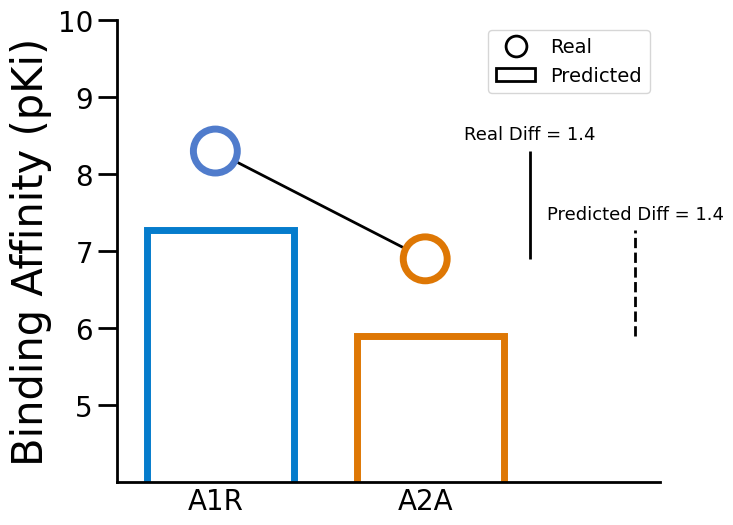

In [11]:
#@title 1. PSICHIC Predicted DPCPX Selective Difference
which_ligand = 'DPCPX'

psichic_selectivity_df = pd.read_csv(jobname+"/screening.csv")


## assign functional effect class based on the one with highest probability
def class_predicted(class_num):
    if class_num == 0:
        return 'Antagonist'
    elif class_num == 1:
        return 'Non-binder'
    elif class_num == 2:
        return 'Agonist'

psichic_selectivity_df['predicted_functional_class'] = [class_predicted(i) for i in psichic_selectivity_df.iloc[:,-3:].values.argmax(axis=1)]


which_df = psichic_selectivity_df[psichic_selectivity_df.ID.apply(lambda x: which_ligand in x)].copy()


which_df['subtype'] = which_df.ID.apply(lambda x: x.split('_')[0])
which_df = which_df[which_df['subtype'].isin(['A1R','A2A'])]
#@title 2. PSICHIC<sub>XL</sub> Interaction Property Prediction
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import Button, Layout, jslink, IntText, IntSlider
import io
import IPython
from ipywidgets import GridspecLayout
from ipywidgets import Output


# Data
constructs = which_df['subtype'].tolist()
predicted_values = which_df['predicted_binding_affinity'].tolist()
scatter_y = which_df['IUPHAR Affinity'].tolist()

# Visual settings
bar_colors = ['white', 'white','white','white']
outline_colors = ['#057CCC', '#DE7704','#843C0C', '#BF8FAD']
scatter_colors = ['#507CCC', '#DE7704','#843C0C', '#BF8FAD']
line_color = 'black'


# Plot settings
x_start = 5
x = np.arange(len(constructs)) + x_start
width = 0.35
fig, ax = plt.subplots(figsize=(7, 6))
adjusted_width = 0.7
line_width = 5  # Width of the outline
# Create bars
for i, x_val in enumerate(x):
    bar = ax.bar(x_val, predicted_values[i], adjusted_width,
                 color=bar_colors[i], capsize=5,
                 edgecolor=outline_colors[i], linewidth=5)
    for rect in bar:
        rect.set_x(rect.get_x() + (line_width / 200))

# Scatter plot data (assumed to be centered)
scatter_x_centered = x  # Adjust if necessary
ax.scatter(scatter_x_centered, scatter_y, s=1000, zorder=5,color='white',edgecolors=scatter_colors,linewidths=5)
ax.plot(scatter_x_centered, scatter_y, color='black',linewidth=2,linestyle='-')

# Customize plot
ax.set_ylim(4., 9.)
ax.tick_params(axis='y', which='major', labelsize=8, length=14, width=2, color='black')
ax.tick_params(axis='x', which='major', labelsize=8, length=0, width=2, color='black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([5,6,7,8,9,10])
ax.set_yticklabels([5,6,7,8,9,10], fontsize=20)  # Set y-tick font size
ax.set_ylabel('Binding Affinity (pKi)', fontsize=30)  # If you have a y-axis label, put the text in the quotes

ax.set_xticks(x)
ax.set_xticklabels(constructs,fontsize=20)


# Create custom legends
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
legend_fontsize = 14
real_legend = mlines.Line2D([], [], color='white', marker='o', markersize=15, label='Real', markeredgewidth=2, markeredgecolor='black', linestyle='None')
prediction_legend = mpatches.Patch(facecolor='white', label='Predicted', edgecolor='black', linewidth=2)  # Set facecolor and edgecolor separately
ax.legend(handles=[real_legend, prediction_legend], fontsize=legend_fontsize)



i = 0
j = 1
### Real difference
y_val_i = scatter_y[0]
y_val_j = scatter_y[1]
line_height = max(y_val_i, y_val_j)
# X positions for the bars
x_i = x[i]
x_j = x[j]
# Draw vertical line
ax.vlines(x=x_j+0.5, ymin=min(y_val_i, y_val_j), ymax=line_height, color='black', linewidth=2)
difference = abs(y_val_i - y_val_j)
# Add annotation with the difference
ax.text(x_j+0.5, line_height + 0.1, f'Real Diff = {difference:.1f}', ha='center', va='bottom', color='black', fontsize=13)

### Predicted difference
y_val_i = predicted_values[0]
y_val_j = predicted_values[1]
line_height = max(y_val_i, y_val_j)
# X positions for the bars
x_i = x[i]
x_j = x[j]
# Draw vertical line
ax.vlines(x=x_j+1, ymin=min(y_val_i, y_val_j), ymax=line_height, color='black', linestyle='dashed', linewidth=2)
difference = abs(y_val_i - y_val_j)
# Add annotation with the differenc
ax.text(x_j+1, line_height + 0.1, f'Predicted Diff = {difference:.1f}', ha='center', va='bottom', color='black', fontsize=13)

plt.show()

In [12]:
#@title 2. PSICHIC Ligand Interpretation: DPCPX-A<sub>1</sub>R = DPCPX-A<sub>2A</sub>R
#@title 3. PSICHIC<sub>XL</sub> Ligand Interpretation - Atom Importance Scores
import pickle
import IPython.core.display as core_display

a1r_path = '{}/interpretation_result/A1R_DPCPX/ligand.pkl'.format(jobname)
a2a_path = '{}/interpretation_result/A2A_DPCPX/ligand.pkl'.format(jobname)

def draw_mol(mol_path):
    with open(mol_path,'rb') as f:
        mol = pickle.load(f)

    ligand_contribs = []
    for idx, atom in enumerate(mol.GetAtoms()):
        psichic_atom_score = atom.GetProp("PSICHIC_Atom_Score")
        atom.SetProp('score',psichic_atom_score)
        ligand_contribs.append(float(psichic_atom_score.replace('[','').replace(']','')))


    d1 = Draw.MolDraw2DSVG(500, 500)
    def make_darker(color, scale):
        r, g, b, a = color
        return (r * scale, g * scale, b * scale, a)

    start_color = mcolors.hex2color('#40d0e0')
    middle_color = mcolors.hex2color('white')
    end_color = mcolors.hex2color('#40d0e0')
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'custom_cmap', [start_color, middle_color, end_color])
    darker_first_color = make_darker(cmap(0), 0.8)
    darker_last_color = make_darker(cmap(1), 0.8)

    colorMap = LinearSegmentedColormap.from_list('Wistia', [darker_first_color, (1.0, 1.0, 1.0), darker_last_color], N=255)
    SimilarityMaps.GetSimilarityMapFromWeights(mol, ligand_contribs, draw2d=d1, contourLines=10, colorMap=colorMap, sigma=0.7)
    d1.FinishDrawing()
    svg1 = SVG(d1.GetDrawingText())
    return svg1


grid = GridspecLayout(1,2, layout=Layout(width='80%', height='80%'))

a1r = Output()
with a1r:
    IPython.display.display(core_display.HTML("<h2 style='text-align: center; font-size: 24px;'>A1R</h2>"))
    IPython.display.display(draw_mol(a1r_path))
grid[0,0] = a1r

a2a = Output()
with a2a:
    IPython.display.display(core_display.HTML("<h2 style='text-align: center; font-size: 24px;'>A2A</h2>"))
    IPython.display.display(draw_mol(a2a_path))
grid[0,1] = a2a


IPython.display.display(grid)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [20]:
#@title 4. PSICHIC<sub>XL</sub> Protein Interpretation: Selecitivity Determinant Identified!
from rdkit.Chem import AllChem
from rdkit import Chem
import numpy as np
import warnings
import os
import Bio.PDB as PDB


# Suppress specific warnings
from Bio import BiopythonWarning
warnings.filterwarnings("ignore", category=BiopythonWarning)

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


atom_types = [
    'N', 'CA', 'C', 'CB', 'O', 'CG', 'CG1', 'CG2', 'OG', 'OG1', 'SG', 'CD',
    'CD1', 'CD2', 'ND1', 'ND2', 'OD1', 'OD2', 'SD', 'CE', 'CE1', 'CE2', 'CE3',
    'NE', 'NE1', 'NE2', 'OE1', 'OE2', 'CH2', 'NH1', 'NH2', 'OH', 'CZ', 'CZ2',
    'CZ3', 'NZ', 'OXT'
]

atom_order = {atom_type: i for i, atom_type in enumerate(atom_types)}
atom_type_num = len(atom_types)  # := 37.


from Bio.PDB import PDBParser
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import io
biopython_parser = PDBParser()

one_to_three = {"A" : "ALA",
              "C" : "CYS",
              "D" : "ASP",
              "E" : "GLU",
              "F" : "PHE",
              "G" : "GLY",
              "H" : "HIS",
              "I" : "ILE",
              "K" : "LYS",
              "L" : "LEU",
              "M" : "MET",
              "N" : "ASN",
              "P" : "PRO",
              "Q" : "GLN",
              "R" : "ARG",
              "S" : "SER",
              "T" : "THR",
              "V" : "VAL",
              "W" : "TRP",
              "Y" : "TYR",
              "B" : "ASX",
              "Z" : "GLX",
              "X" : "UNK",
              "*" : " * "}

three_to_one = {}
for _key, _value in one_to_three.items():
    three_to_one[_value] = _key
three_to_one["SEC"] = "C"
three_to_one["MSE"] = "M"

def overwrite_b_factors(protein_path,
                        custom_bfactors: np.ndarray,
                        res_symbols: list,
                        save_path=None) -> str:


    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('', protein_path)[0]

    curr_resid = ('', '', '')
    idx = -1
    a_list = []
    for i, chain in enumerate(structure):
        for res_idx, residue in enumerate(chain):
            if residue.get_resname() == 'HOH':
                for atom in residue:
                    atom.bfactor = 0

            c_alpha, n, c = None, None, None
            for atom in residue:
                if atom.name == 'CA':
                    c_alpha = list(atom.get_vector())
                if atom.name == 'N':
                    n = list(atom.get_vector())
                if atom.name == 'C':
                    c = list(atom.get_vector())
            if c_alpha != None and n != None and c != None:
                idx += 1

                for atom in residue:
                    ##### ensure visualization SEQ follows pre-processed SEQ
                    try:
                        pdb_res_symbol = three_to_one[residue.get_resname()]
                    except Exception as e:
                        pdb_res_symbol = 'X'
                        # print("encountered unknown AA: ", residue.get_resname(), ' in the complex. Replacing it with a dash X.')

                    if res_symbols[idx] != pdb_res_symbol:
                        raise Exception('Result sequence symbol {} does not match with PDB sequence symbol {}'.format(res_symbols[idx],pdb_res_symbol))

                    atom.bfactor = custom_bfactors[idx]
            else:
                for atom in residue:
                    atom.bfactor = 0
    if save_path is None:
        path_out = 'temporary.txt'
    else:
        path_out = save_path
    new_pdb = io.StringIO()
    pdb_io = PDB.PDBIO()
    pdb_io.set_structure(structure)
    pdb_io.save(path_out)

    with open(path_out,'r') as f:
        out = f.read()

    return out

def extract_pdb_seq(protein_path):

    structure = biopython_parser.get_structure('random_id', protein_path)[0]
    seq = ''
    chain_str = ''
    for i, chain in enumerate(structure):
        for res_idx, residue in enumerate(chain):
            if residue.get_resname() == 'HOH':
                continue
            residue_coords = []
            c_alpha, n, c = None, None, None
            for atom in residue:
                if atom.name == 'CA':
                    c_alpha = list(atom.get_vector())
                if atom.name == 'N':
                    n = list(atom.get_vector())
                if atom.name == 'C':
                    c = list(atom.get_vector())
            if c_alpha != None and n != None and c != None:  # only append residue if it is an amino acid and not
                try:
                    seq += three_to_one[residue.get_resname()]
                    chain_str += str(chain.id)
                except Exception as e:
                    seq += 'X'
                    chain_str += str(chain.id)
                    print("encountered unknown AA: ", residue.get_resname(), ' in the complex. Replacing it with a dash X.')

    return seq, chain_str

from Bio import pairwise2
from Bio.pairwise2 import format_alignment

def psichic_align_scores(seqA_df, seqB):
    seqA = "".join(seqA_df['Residue_Type'].tolist())
    seqA_scores = seqA_df['PSICHIC_Residue_Score'].tolist()

    alignments = pairwise2.align.globalxx(seqA,seqB)
    best_alignment = alignments[0]

    ori_res_id = []
    pdb_scores = []
    counter = 0
    for seqA_res in best_alignment.seqA:
        if seqA_res != "-":
            pdb_scores.append(seqA_scores[counter])
            ori_res_id.append(counter+1)
            counter +=1
        else:
            ori_res_id.append(None)
            pdb_scores.append(None)

    seq_scores = [score for score, res in zip(pdb_scores,list(best_alignment.seqB)) if res !='-']
    ori_res_id = [idx for idx, res in zip(ori_res_id,list(best_alignment.seqB)) if res !='-']
    out_df = pd.DataFrame({'Original_Residue_ID': ori_res_id,
                           'Residue_ID':[i+1 for i in range(len(seqB))],
                'Residue_Type':list(seqB),
                'PSICHIC_Residue_Score':seq_scores})
    out_df['PSICHIC_Residue_Percentile'] = out_df['PSICHIC_Residue_Score'].rank(pct=True)
    return out_df


which_subtype = "A1R"
subtype=which_subtype
structure_path = 'selectivity/ar_structures/{}_{}.pdb'.format(which_ligand.lower(),subtype.lower())
protein_df = pd.read_csv("{}/interpretation_result/{}_{}/protein.csv".format(jobname,subtype,which_ligand))
pdb_seq, pdb_chain = extract_pdb_seq(structure_path)
aligned_pdb = psichic_align_scores(protein_df,pdb_seq)


if not os.path.exists(f'{jobname}/pymol_results'):
     os.makedirs(f'{jobname}/pymol_results')
pdb_block = overwrite_b_factors(structure_path,
                                aligned_pdb['PSICHIC_Residue_Percentile'].fillna(0).round(2).clip(0.01,0.99).tolist(),
                                pdb_seq,
                                save_path='{}/pymol_results/{}_{}_bfactor_annotated.pdb'.format(jobname,which_ligand,subtype))

a1r_residue_score = aligned_pdb[aligned_pdb['Original_Residue_ID'] == 270]['PSICHIC_Residue_Percentile'].item()


which_subtype = "A2A"
subtype=which_subtype
structure_path = 'selectivity/ar_structures/{}_{}.pdb'.format(which_ligand.lower(),subtype.lower())
protein_df = pd.read_csv("{}/interpretation_result/{}_{}/protein.csv".format(jobname,subtype,which_ligand))
pdb_seq, pdb_chain = extract_pdb_seq(structure_path)
aligned_pdb = psichic_align_scores(protein_df,pdb_seq)


if not os.path.exists(f'{jobname}/pymol_results'):
     os.makedirs(f'{jobname}/pymol_results')
pdb_block = overwrite_b_factors(structure_path,
                                aligned_pdb['PSICHIC_Residue_Percentile'].fillna(0).round(2).clip(0.01,0.99).tolist(),
                                pdb_seq,
                                save_path='{}/pymol_results/{}_{}_bfactor_annotated.pdb'.format(jobname,which_ligand,subtype))

a2a_residue_score = aligned_pdb[aligned_pdb['Original_Residue_ID'] == 270]['PSICHIC_Residue_Percentile'].item()


grid = GridspecLayout(2,2, layout=Layout(width='80%', height='80%'))

a1r = Output()
with a1r:
    IPython.display.display(core_display.HTML("<h2 style='text-align: center; font-size: 24px;'>A<sub>1</sub>R-T270 PSICHIC Residue Score</h2>"))
    IPython.display.display(core_display.HTML(f"<h2 style='text-align: center; font-size: 24px;'>{a1r_residue_score:4f}</h2>"))
grid[0,0] = a1r

a2a = Output()
with a2a:
    IPython.display.display(core_display.HTML("<h2 style='text-align: center; font-size: 24px;'>A<sub>2A</sub>R-M270 PSICHIC Residue Score</h2>"))
    IPython.display.display(core_display.HTML(f"<h2 style='text-align: center; font-size: 24px;'>{a2a_residue_score:4f}</h2>"))
grid[0,1] = a2a


summ1 = Output()
with summ1:
    IPython.display.display(core_display.HTML("<h2 style='text-align: right; font-size: 24px;'>19x</h2>"))
grid[1,0] = summ1

summ2 = Output()
with summ2:
    IPython.display.display(core_display.HTML("<h2 style='text-align: left; font-size: 24px;'>&nbsp;&nbsp;Difference!</h2>"))
grid[1,1] = summ2


IPython.display.display(grid)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…



1.   DPCPX is a selective ligand for A₁R over A₂AR, with a 1.4 log unit pKᵢ selectivity difference.

2.   PSICHICₓₗ predictions are consistent with the known structure of the A₁R-DU172 complex, particularly regarding the interactions of the DPCPX ring and the 6-oxy group with specific residues.

3. Despite similar ligand interpretations for A₁R and A₂AR, PSICHICₓₗ predicts selectivity based on differences in protein residue interactions between the two subtypes.

4. PSICHICₓₗ assigned high importance scores to most binding site residues for both A₁R and A₂AR, but identified five A₂AR residues with low importance scores(<0.05), highlighting M270 as a key determinant of selectivity.

5. The residue M270 in A₂AR, which is not conserved in A₁R (where it is T270), acts as a 'gatekeeper' affecting ligand access to the binding site, influencing DPCPX selectivity.


Experimental data supports the role of T270 in A₁R and M270 in A₂AR in determining ligand affinity, with mutations at this position significantly altering DPCPX binding affinity. See our previous study ([paper link](https://pubmed.ncbi.nlm.nih.gov/28235198/)).